In [4]:
import pandas as pd

# Load the dataset
df_kaggle = pd.read_csv("E:\Spectrum\Project 7\Dataset\Loan Dataset.csv")

# Check structure
print(df_kaggle.shape)
print(df_kaggle.info())
print(df_kaggle.head())


(52000, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52000 entries, 0 to 51999
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Applicant_ID                52000 non-null  int64  
 1   Gender                      52000 non-null  object 
 2   Age                         52000 non-null  int64  
 3   Marital_Status              52000 non-null  object 
 4   Dependents                  52000 non-null  int64  
 5   Education                   52000 non-null  object 
 6   Employment_Status           52000 non-null  object 
 7   Occupation_Type             52000 non-null  object 
 8   Residential_Status          52000 non-null  object 
 9   City/Town                   52000 non-null  object 
 10  Annual_Income               52000 non-null  int64  
 11  Monthly_Expenses            52000 non-null  int64  
 12  Credit_Score                52000 non-null  int64  
 13  Existing_Loans     

<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15540\2218419793.py:4: SyntaxWarning: invalid escape sequence '\S'
  df_kaggle = pd.read_csv("E:\Spectrum\Project 7\Dataset\Loan Dataset.csv")


In [5]:
# Clean column names
df_kaggle.columns = df_kaggle.columns.str.strip().str.lower()

# Verify target column
print(df_kaggle['loan_approval_status'].value_counts())

loan_approval_status
1    33366
0    18634
Name: count, dtype: int64


In [6]:
# Drop ID column
df_kaggle.drop('applicant_id', axis=1, inplace=True)

# Separate numeric and categorical
numeric_cols = df_kaggle.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('loan_approval_status')  # remove target

categorical_cols = df_kaggle.select_dtypes(include=['object']).columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['age', 'dependents', 'annual_income', 'monthly_expenses', 'credit_score', 'existing_loans', 'total_existing_loan_amount', 'outstanding_debt', 'loan_history', 'loan_amount_requested', 'loan_term', 'interest_rate', 'bank_account_history', 'transaction_frequency', 'default_risk']
Categorical: ['gender', 'marital_status', 'education', 'employment_status', 'occupation_type', 'residential_status', 'city/town', 'loan_purpose', 'loan_type', 'co-applicant']


In [7]:
# Define groups for comparison
approved = df_kaggle[df_kaggle['loan_approval_status'] == 1]
not_approved = df_kaggle[df_kaggle['loan_approval_status'] == 0]

print("Approved count:", len(approved))
print("Not Approved count:", len(not_approved))

Approved count: 33366
Not Approved count: 18634


In [8]:
from scipy.stats import ttest_ind
import pandas as pd

# T-test results list
t_test_results = []

for col in numeric_cols:
    stat, pval = ttest_ind(approved[col], not_approved[col], equal_var=False)
    t_test_results.append({
        'Feature': col,
        'Approved_Mean': approved[col].mean(),
        'Not_Approved_Mean': not_approved[col].mean(),
        'T-Statistic': stat,
        'P-Value': pval,
        'Significant (p<0.05)': 'Yes' if pval < 0.05 else 'No'
    })

# Create results DataFrame
ttest_df = pd.DataFrame(t_test_results)
ttest_df.sort_values('P-Value', inplace=True)
ttest_df.reset_index(drop=True, inplace=True)

# Display top features
ttest_df


,Feature,Approved_Mean,Not_Approved_Mean,T-Statistic,P-Value,Significant (p<0.05)
0,annual_income,96192.044237,61020.549587,121.739534,0.000000e+00,Yes
1,credit_score,751.855602,546.002737,154.679021,0.000000e+00,Yes
2,loan_amount_requested,24222.823383,15515.996565,126.359974,0.000000e+00,Yes
3,age,37.449679,41.492433,-37.323653,3.582683e-297,Yes
4,interest_rate,9.275557,9.213989,2.028168,4.254998e-02,Yes
5,total_existing_loan_amount,24999.249236,24831.363314,1.276967,2.016214e-01,No
6,default_risk,0.499097,0.502186,-1.164542,2.442115e-01,No
7,loan_term,126.055056,125.418697,1.063942,2.873617e-01,No
8,existing_loans,1.000629,0.992916,1.032337,3.019207e-01,No
9,monthly_expenses,2751.712971,2741.532629,0.860054,3.897645e-01,No


In [9]:
from scipy.stats import f_oneway

anova_results = []

for cat in categorical_cols:
    if df_kaggle[cat].nunique() > 2:  # Only for 3+ levels
        for num in ['annual_income', 'credit_score']:
            groups = [df_kaggle[df_kaggle[cat] == level][num] for level in df_kaggle[cat].unique()]
            f_stat, p_val = f_oneway(*groups)
            anova_results.append({
                'Categorical Feature': cat,
                'Numeric Feature': num,
                'F-Statistic': f_stat,
                'P-Value': p_val,
                'Significant (p<0.05)': 'Yes' if p_val < 0.05 else 'No'
            })

anova_df = pd.DataFrame(anova_results)
anova_df.sort_values('P-Value', inplace=True)
anova_df


,Categorical Feature,Numeric Feature,F-Statistic,P-Value,Significant (p<0.05)
13,loan_purpose,credit_score,2.937020,0.031921,Yes
5,employment_status,credit_score,2.378126,0.092734,No
4,employment_status,annual_income,2.053873,0.128248,No
9,residential_status,credit_score,1.729162,0.177443,No
12,loan_purpose,annual_income,0.825792,0.479400,No
10,city/town,annual_income,0.716767,0.488333,No
6,occupation_type,annual_income,0.758574,0.517193,No
8,residential_status,annual_income,0.648675,0.522742,No
11,city/town,credit_score,0.421713,0.655924,No
7,occupation_type,credit_score,0.485098,0.692628,No


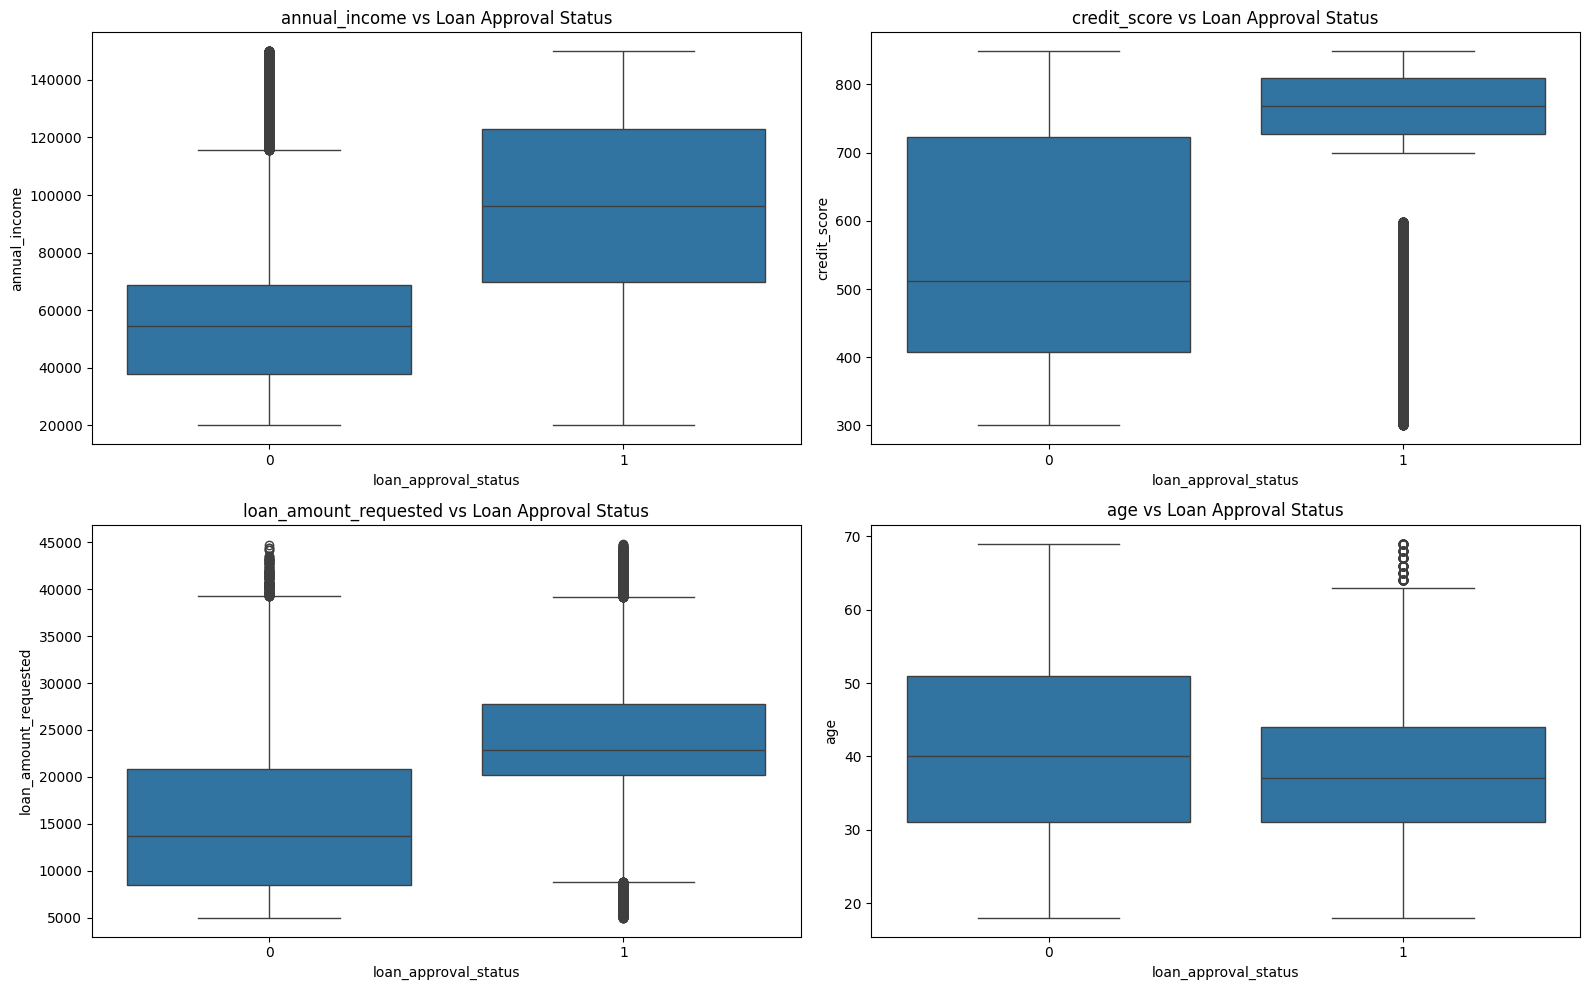

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = ['annual_income', 'credit_score', 'loan_amount_requested', 'age']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='loan_approval_status', y=feature, data=df_kaggle)
    plt.title(f'{feature} vs Loan Approval Status')
plt.tight_layout()
plt.show()
